In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt

import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.models as models
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd

In [2]:
l1_reg = funcs2.AbsoluteNorm()
l2_reg = funcs2.SquareNorm()
lq_reg = funcs2.PowerNorm(1.001)
softl1_reg = funcs2.SoftAbsoluteNorm(0.00001)

In [3]:
def plot_params(mod):
    plt.figure(figsize=(5,4))
    cc = plt.imshow(mod.param.base[1:].reshape(8,8), cmap=plt.cm.RdBu)
    cb = plt.colorbar(cc)
    plt.show()

In [4]:
digits = load_digits()

In [5]:
Y = np.ascontiguousarray(digits.target)
X = np.ascontiguousarray(digits.data)
print(len(Y))

1797


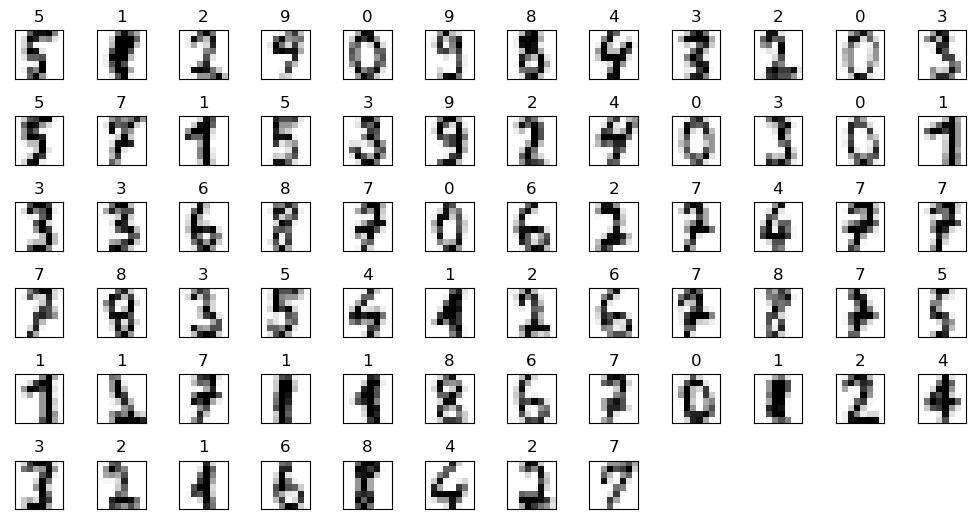

In [6]:
I = np.random.randint(0,len(Y),96)
II = I.reshape(8,12)
plt.figure(figsize=(10,7))
for i in range(8):
    for j in range(12):
        plt.subplot(8,12,8*i+j+1)
        plt.imshow(X[II[i,j]].reshape(8,8), cmap=plt.cm.Greys)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(Y[II[i,j]]))
plt.tight_layout()
plt.show()

In [7]:
I1 = (Y == 1)
I7 = (Y == 7)
X1 = X[I1]
Y1 = np.ones(len(X1), 'd')
X7 = X[I7]
Y7 = -np.ones(len(X7), 'd')

X17 = np.concatenate((X1, X7), axis=0)
Y17 = np.concatenate((Y1, Y7))

N = len(Y17)
print(X17.shape, Y17.shape)

(361, 64) (361,)


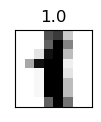

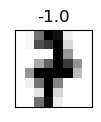

In [8]:
plt.figure(figsize=(1,1))
plt.imshow(X17[0].reshape(8,8), plt.cm.Greys)
plt.title(str(Y17[0]))
plt.xticks([])
plt.yticks([])
plt.show()
plt.figure(figsize=(1,1))
plt.imshow(X17[-1].reshape(8,8), plt.cm.Greys)
plt.title(str(Y17[-1]))
plt.xticks([])
plt.yticks([])
plt.show()

### Линейное разделение (функция Хинжа, без регуляризации)

$$
w^\star = \arg \min_{\mathbf{w}} 
\frac{1}{N}\sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr)
$$
$$
H(u) = \max(-u,0)
$$

In [9]:
hinge_loss = loss.MarginLoss(funcs.Hinge(0.0))
sq_loss = loss.SquareErrorLoss()

In [10]:
mod1 = models.LinearModel(64) # линейная модель

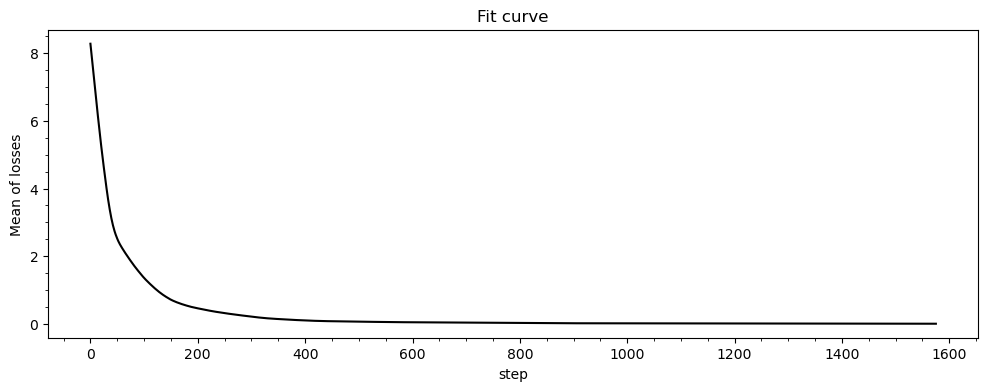

Относительное число правильных ответов: 1.0


In [11]:
alg1 = cls.classification_as_regr(X17, Y17, mod1,
                                  lossfunc=hinge_loss, 
                                  normalizer=gd.Masked(mod1, 1.0e-9),
                                  h=0.001, n_iter=10000)

plt.figure(figsize=(12,4))
plots.plot_losses(alg1, X17, Y17)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(Y17, np.sign(mod1.evaluate_all(X17))))

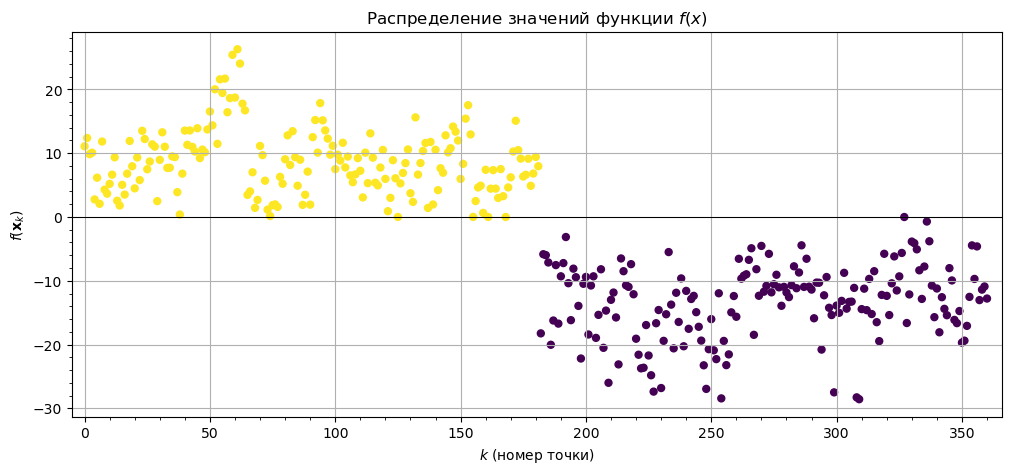

In [12]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1, X17, Y17)
plt.show()

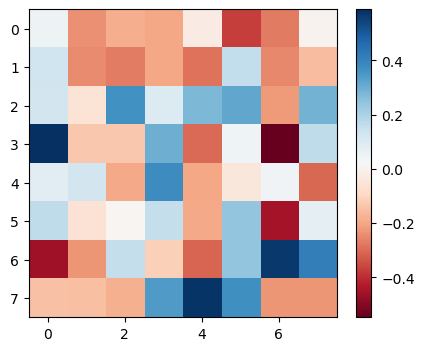

In [13]:
plot_params(mod1)

### Линейное разделение (функция Хинжа, L2 регуляризация)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_2^2,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [14]:
mod2 = models.LinearModel(64)

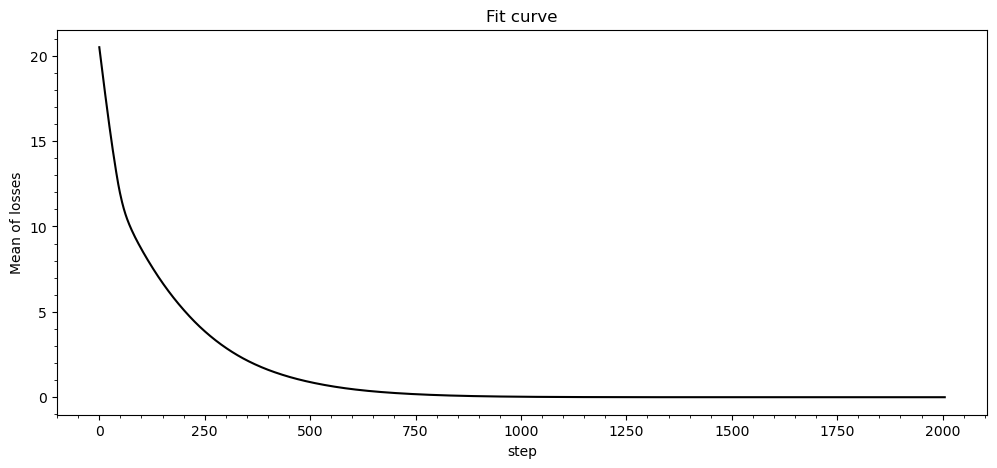

Относительное число правильных ответов: 1.0


In [15]:
alg2 = cls.classification_as_regr(X17, Y17, mod2,
                                 lossfunc=hinge_loss, 
                                 regnorm=l2_reg, tau=5.0,
                                 normalizer=gd.Masked(mod2, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2, X17, Y17)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(Y17, np.sign(mod2.evaluate_all(X17))))

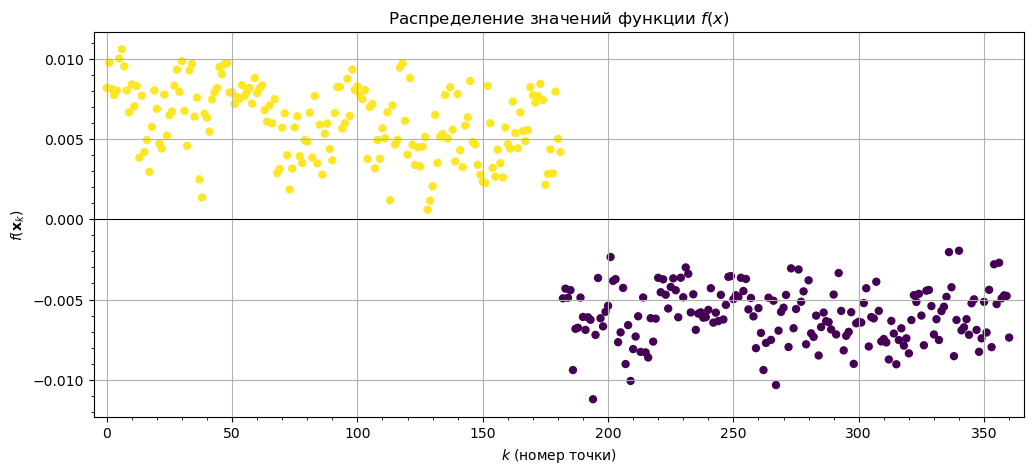

In [16]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2, X17, Y17)
plt.show()

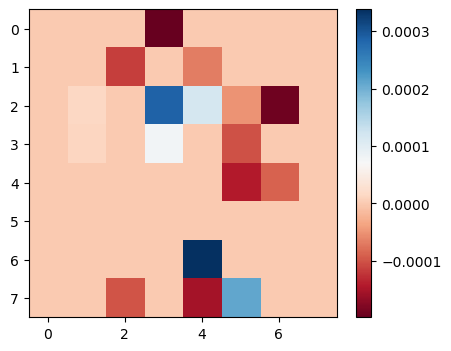

In [17]:
plot_params(mod2)

In [18]:
mod_pairs = {}
alg_pairs = {}
for i in range(9):
    for j in range(i+1,10):
        mod_pairs[(i,j)] = mod = models.LinearModel(64)
        II = (Y == i)
        IJ = (Y == j)
        XI = X[II]
        YI = np.ones(len(XI), 'd')
        XJ = X[IJ]
        YJ = -np.ones(len(XJ), 'd')
        
        XIJ = np.concatenate((XI, XJ), axis=0)
        YIJ = np.concatenate((YI, YJ))

        alg_pairs[(i,j)] = alg = cls.classification_as_regr(
                                 XIJ, YIJ, mod,
                                 lossfunc=hinge_loss, 
                                 regnorm=l2_reg, tau=0.1,
                                 normalizer=gd.Masked(mod2, 1.0e-5),
                                 h=0.1, n_iter=5000)
        p = mod.param.base
        mod.param.base[:] = mod.param.base / np.sqrt(p @ p)
        print(f"({i},{j}):", metrics.accuracy_score(YIJ, np.sign(mod.evaluate_all(XIJ))))

(0,1): 0.9944444444444445
(0,2): 1.0
(0,3): 1.0
(0,4): 1.0
(0,5): 0.9944444444444445
(0,6): 1.0
(0,7): 1.0
(0,8): 1.0
(0,9): 1.0
(1,2): 1.0
(1,3): 1.0
(1,4): 1.0
(1,5): 1.0
(1,6): 1.0
(1,7): 1.0
(1,8): 1.0
(1,9): 0.9917127071823204
(2,3): 1.0
(2,4): 1.0
(2,5): 0.9972144846796658
(2,6): 1.0
(2,7): 1.0
(2,8): 1.0
(2,9): 1.0
(3,4): 1.0
(3,5): 1.0
(3,6): 0.9862637362637363
(3,7): 1.0
(3,8): 1.0
(3,9): 1.0
(4,5): 1.0
(4,6): 1.0
(4,7): 1.0
(4,8): 1.0
(4,9): 1.0
(5,6): 1.0
(5,7): 1.0
(5,8): 1.0
(5,9): 0.9972375690607734
(6,7): 0.9972222222222222
(6,8): 1.0
(6,9): 1.0
(7,8): 1.0
(7,9): 1.0
(8,9): 1.0


In [19]:
def decision_func_array(mod_pairs, x):
    d = np.zeros((10,10), 'd')
    for i in range(9):
        for j in range(i+1,10):
            mod = mod_pairs[(i,j)]
            yp = np.sign(mod.evaluate_all(x[None,:]))
            d[i,j] = yp
            d[j,i] = -yp
    return d

def decision_func(mod_pairs, x):
    d = decision_func_array(mod_pairs, x)
    return np.argmax(np.sum(d, axis=1))
    

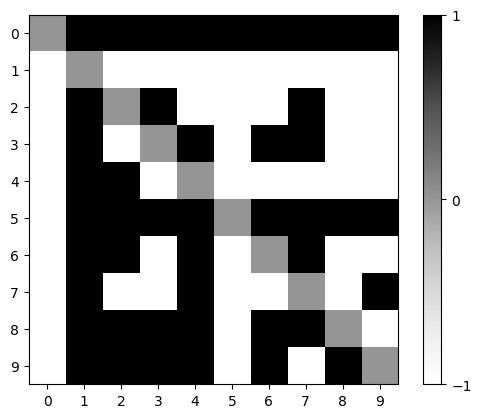

In [20]:
d = decision_func_array(mod_pairs, X[0])
cs = plt.imshow(d, cmap=plt.cm.Greys)
plt.colorbar(cs, ticks=[-1,0,1])
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

In [21]:
print(decision_func(mod_pairs, X[-1]), Y[-1])

8 8


In [22]:
for k in range(len(Y)):
    xk, yk = X[k], Y[k]
    yy = decision_func(mod_pairs, xk)
    if yy != yk:
        print(k, yk, yy)

19 9 1
31 9 1
37 9 5
467 7 5
1274 5 2
1662 9 5


### Линейное разделение (функция Хинжа, L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + 
\tau\|\mathbf{w}\|_1,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [23]:
mod3 = models.LinearModel(64)

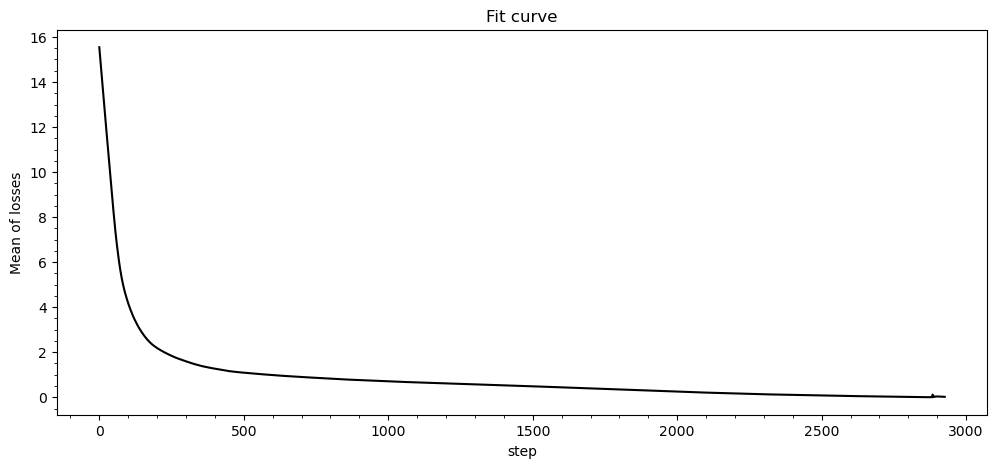

Относительное число правильных ответов: 0.9889196675900277


In [24]:
alg3 = cls.classification_as_regr(X17, Y17, mod3,
                                 lossfunc=hinge_loss, 
                                 regnorm=l1_reg, tau=0.1,
                                 normalizer=gd.Masked(mod2, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3, X17, Y17)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(Y17, np.sign(mod3.evaluate_all(X17))))

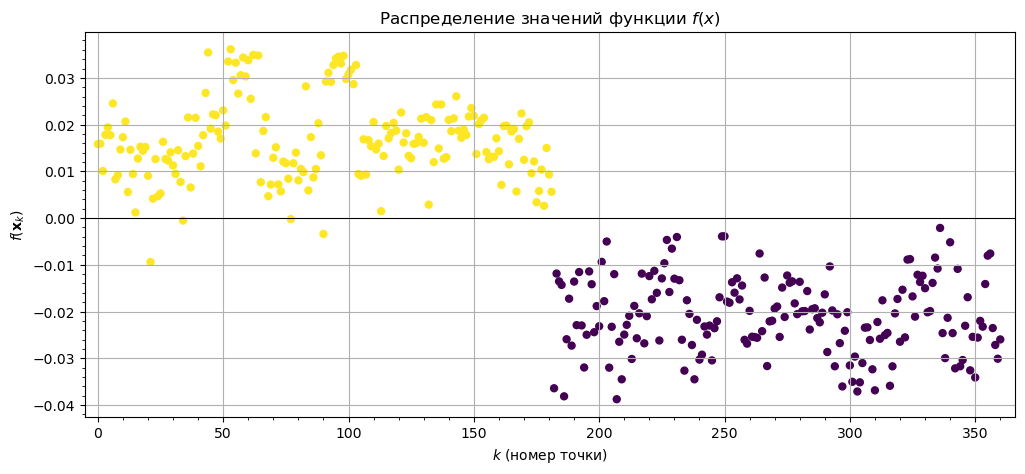

In [25]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3, X17, Y17)
plt.show()

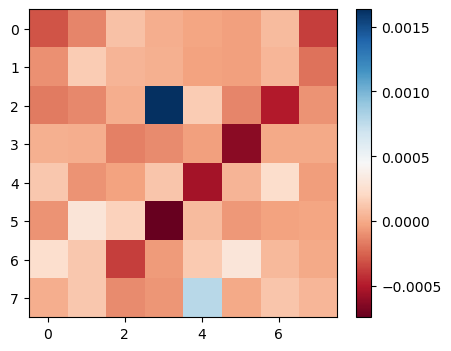

In [26]:
plot_params(mod3)

## Линейное разделение (сигмоидальная функция)

$$
y = \sigma\bigl(w_0 + (\mathbf{w},\mathbf{x})\bigr)
$$
где
$$
\sigma(s) = \mathrm{th}(s) = \frac{e^{\alpha x} - e^{-\alpha x}}{e^{\alpha x} + e^{-\alpha x}}
$$

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 
$$


In [27]:
sigmoidal_func = funcs.Sigmoidal(1.0)
mod1_s = models.SigmaNeuronModel(sigmoidal_func, 64)

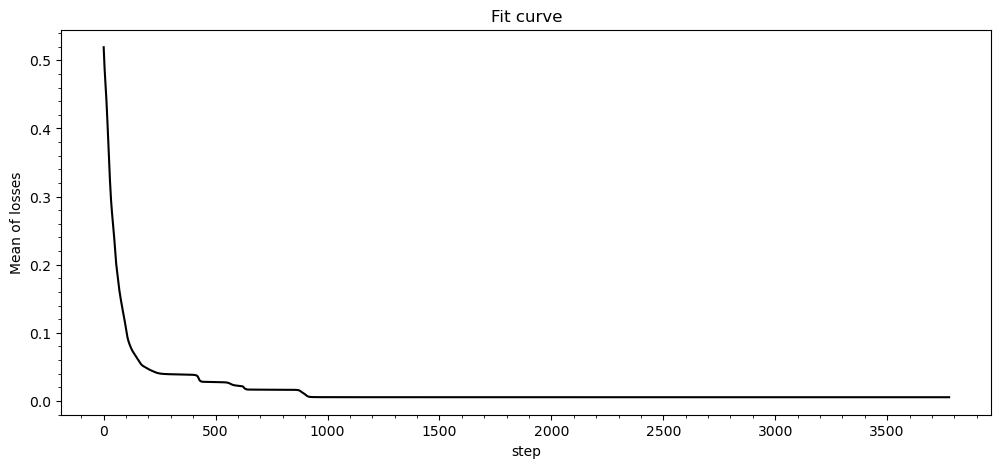

Относительное число правильных ответов: 0.997229916897507


In [28]:
alg1_s = cls.classification_as_regr(X17, Y17, mod1_s,
                                 lossfunc=sq_loss,
                                 # regnorm=l2_reg, tau=0.9,
                                 normalizer=gd.Masked(mod1_s, 1.0e-9),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg1_s, X17, Y17)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(Y17, np.sign(mod1_s.evaluate_all(X17))))

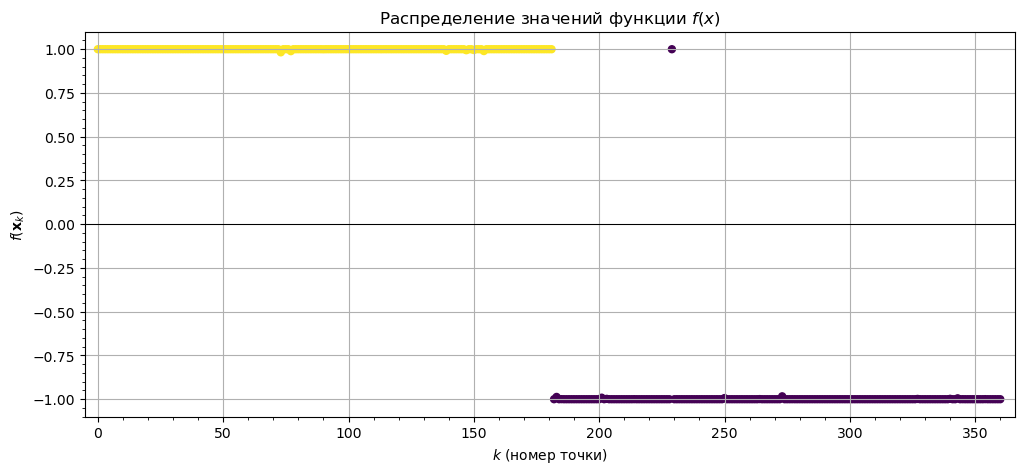

In [29]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1_s, X17, Y17)
plt.show()

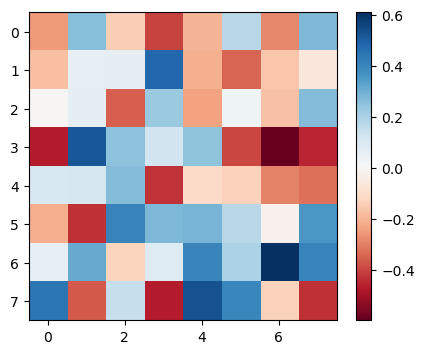

In [30]:
plot_params(mod1_s)

### Линейное разделение (максимизация отступа, с L2 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 + 
\tau\|\mathbf{w}\|_2^2,
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [31]:
sigmoidal_func = funcs.Sigmoidal(1.0)
mod2_s = models.SigmaNeuronModel(sigmoidal_func, 64)

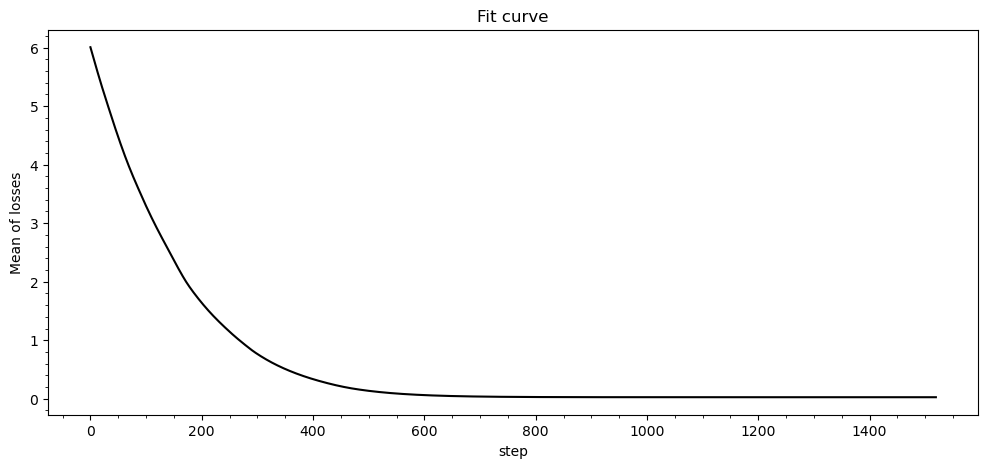

Относительное число правильных ответов: 1.0


In [32]:
alg2_s = cls.classification_as_regr(X17, Y17, mod2_s,
                                 lossfunc=sq_loss,
                                 regnorm=l2_reg, tau=2.0,
                                 normalizer=gd.Masked(mod2_s, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2_s, X17, Y17)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(Y17, np.sign(mod2_s.evaluate_all(X17))))

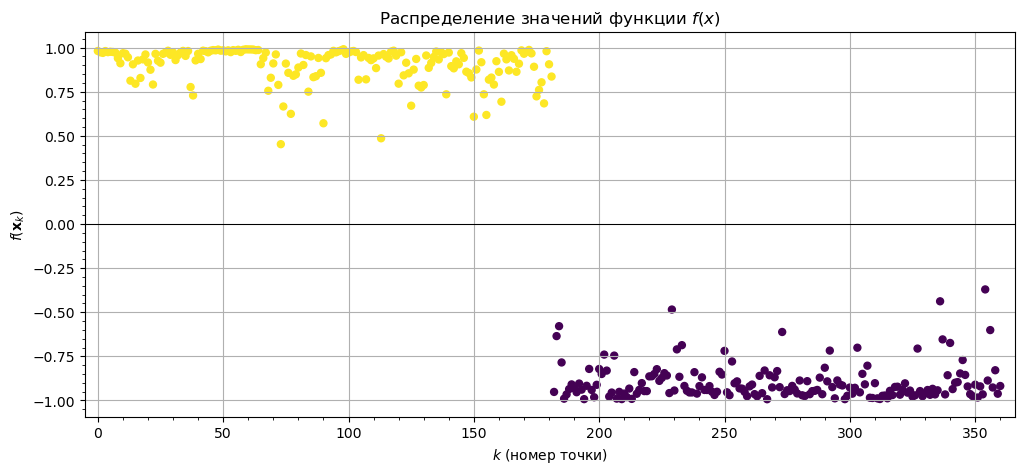

In [33]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2_s, X17, Y17)
plt.show()

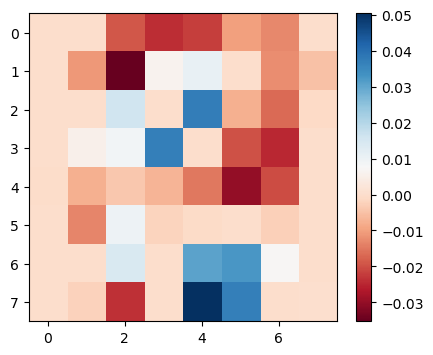

In [34]:
plot_params(mod2_s)

### Линейное разделение (максимизация отступа, с L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\sigma\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_1,
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [35]:
sigmoidal_func = funcs.Sigmoidal(1.0)
mod3_s = models.SigmaNeuronModel(sigmoidal_func, 64)

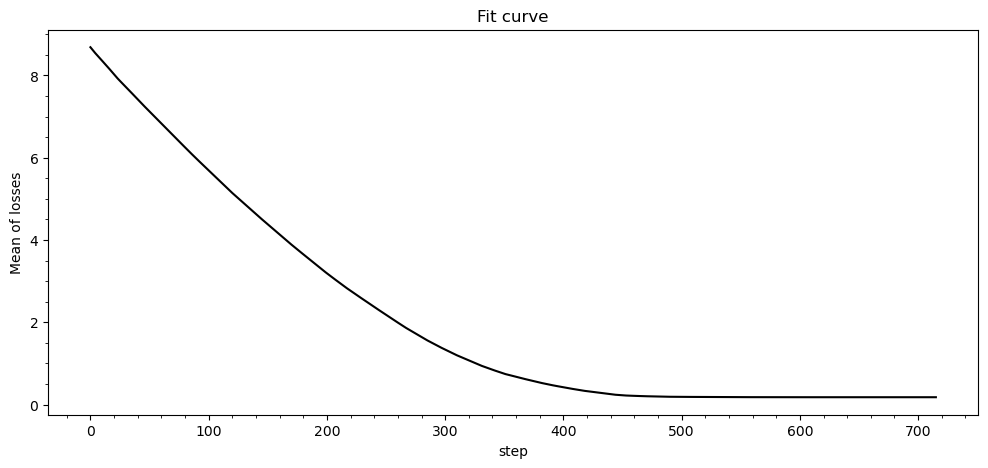

Относительное число правильных ответов: 0.9806094182825484


In [36]:
alg3_s = cls.classification_as_regr(X17, Y17, mod3_s,
                                 lossfunc=sq_loss,
                                 regnorm=l1_reg, tau=0.5,
                                 normalizer=gd.Masked(mod3_s, 1.0e-5),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s, X17, Y17)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(Y17, np.sign(mod3_s.evaluate_all(X17))))

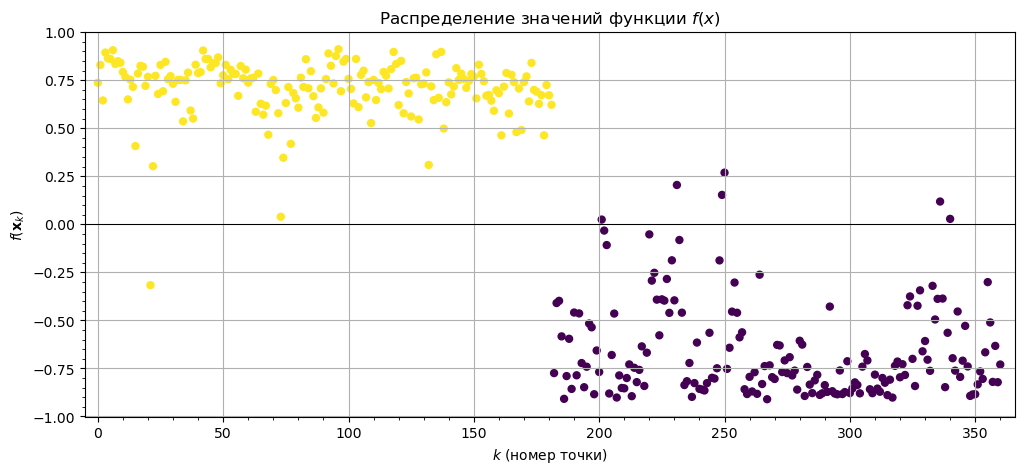

In [37]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s, X17, Y17)
plt.show()

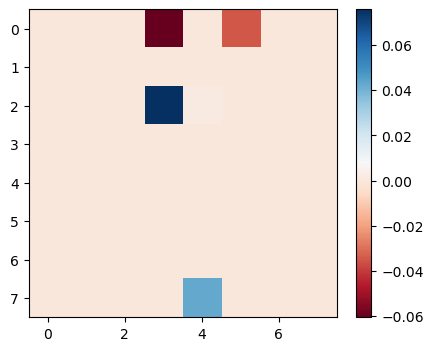

In [38]:
plot_params(mod3_s)